In [147]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

- [0 Introduction](#0-Introduction)
- [1 Data](#1-Data)
  - [1.1 Lending Club Data](#1.1-Lending-Club-Data)
    - [1.1.1 Loan Status](#1.1.1-Loan-Status)
    - [1.1.2 Missing Data](#1.1.2-Missing-Data)
    - [1.1.3 Transform String Variables](#1.1.3-Transform-String-Variables)
    - [1.1.4 Variables with Constant Values](#1.1.4-Variables-with-Constant-Values)
    - [1.1.5 Meaningless Non-predictors](#1.1.5-Meaningless-Non-predictors)
    - [1.1.6 "Post-hoc" Variables](#1.1.6-"Post-hoc"-Variables)
    - [1.1.7 Third party Credit Score](#1.1.7-Third-party-Credit-Score)
    - [1.1.8 Drop Highly-correlated Variables](#1.1.8-Drop-Highly-correlated-Variables)
    - [1.1.9 Transform "annual_inc" to Log Measure](#1.1.9-Transform-"annual_inc"-to-Log-Measure)
    - [1.1.10 Trivial Changes](#1.1.10-Trivial-changes)
  - [1.2 Census Data](#1.2-Census-Data)
  - [1.3 Preprocessing Categorical Variables](#1.3-Preprocessing-Categorical-Variables)

- [2 Analysis](#2-Analysis)
  - [2.1 Visualization and Plots](#2.1-Visualization-and-plots)
    - [2.1.1 Annual Income and Loan Amount](#2.1.1-Annual-Income-and-Loan-Amount)
    - [2.1.2 Debt to Income Ratio and Loan Amount](#2.1.2-Debt-to-Income-Ratio-and-Loan-Amount)
    - [2.1.3 Home Ownership](#2.1.3-Home-Ownership)
  - [2.2 Feature Selection](#2.2-Feature-Selection)
    - [2.2.1 Lasso Regularization](#2.2.1-Lasso-Regularization)
    - [2.2.2 Random Forest Feature Importance](#2.2.2-Random-Forest-Feature-Importance)
    - [2.2.3 Step-wise Backward Feature Selection](#2.2.3-Step-wise-Backward-Feature-Selection)
    - [2.2.4 Features Selection Conclusion](#2.2.4-Features-Selection-Conclusion)
- [3 Classification Models](#3-Classification)
  - [3.1 Performance Evaluation Metrics](#3.1-Performance-Evaluation-Metrics)
  - [3.2 Classification Models](#3.2-Classification-Models)
    - [3.2.1 Logistic Regression Model](#3.2.1-Logistic-Regression-Model)
    - [3.2.2 LDA and QDA](#3.2.2-LDA-and-QDA)
    - [3.2.3 Random Forest](#3.2.3-Random-Forest)
    - [3.2.4 Gradient Boost](#3.2.4-Gradient-Boost)
  - [3.3 Comparison of Different Models](#3.3-Comparison-of-Different-Models)
  - [3.4 Performance Improvements](3.4-Performance-Improvements)
    - [3.4.1 Re-weight Classes](#3.4.1-Re-weight-Classes)
    - [3.4.2 Adjust Threshold](#3.4.2-Adjust-Threshold)
  - [3.5 Replicate Lending Club Credit Grades](#3.5-Replicate-Lending-Club-Credit-Grades)
- [4 Future Work](#4-Future-Work)


In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.linear_model import LogisticRegression as Logit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import LabelEncoder as LabelEncoder
import sklearn.preprocessing as Preprocessing
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler as Standardize
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split


import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from scipy import stats
from itertools import combinations



from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from collections import defaultdict


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Introduction

  Lending Club is the world's largest peer-to-peer online borrowing platform. It connects borrowers with investors in the capital market, and as a result it adds mobility to the market and improves the overall wellfare of the society. Lending Club offers access to a pool of loans with different risks, and meanwhile, Lending Club evaluates the default probability of each loan to assist investors in loan selection and risk control. Accordingly, the interest rates of loans are based on the default probabilities, and are fixed throught the term of the loans. Investors can select loans into their investment portfolio based on their risk and return preference. On the other side, borrowers can select to prepay the loans at any time during the term to eliminate future interest payments without any prepayment penalty or fees.

  This project explores the data of Lending Club loans and predicts the loan outcomes using a variety of classification models. The prediction models are built with accessible information available to all investors, and do not rely on any third-party credit scores, Lending Club credit grades, or interest rates.

# 1. Data 

&nbsp;&nbsp; This project uses the Lending Club loans issued in the first three quarters of 2016, with a total number of 330,867. Each of the loans has one of the status such as "Current", "Fully Paid", "Charged Off", etc. In this project I treat the "Current" status as an unknown status, and focus the analysis on the loans with known status, meaning they are either "Fully Paid" (meaning non-default) or "Default" (including "Charged Off", "Late", "In Grace Period", "Does not meet the credit policy", "Default"). 

&nbsp;&nbsp; For each loan there are 115 features provided, and the description of the features is under also available on from Lending Club website. Variables with more than 10% missing values are dropped from the data set, and for the rest missing data, I used the "impute" function in scikit-learn to fill the missing data with the mean of the variable in the whole data set. 

&nbsp;&nbsp; To get more information about the loans and borrowers, I looked up the borrower's neighborhood average income using zipcode information. Also I pre-processed the data to deal with string type variables (such as issue date), constant or meaningless variables (such as borrower ID), "Post-hoc" variables (such as last payment amount of the loan), and human-generated credit scores. Then, I dropped highly correlated variables (with heatmap) to avoid multicollinearity issue. Lastly, I log-transformed some variables (such as annual income) to ensure normal distributions and to deal with outliers.

# 2. Analysis

## 2.1 Visualization and Plots

&nbsp;&nbsp; Before building the prediction models, I conducted some exploratory data anlysis by visualizing the relationships between some variables and the loan's outcome. 

&nbsp;&nbsp; Firstly, I explored the relationship between the loan's amount and borrower's (log-transformed) annual income and plotted the average annual income of borrowers for different range of loan amounts and for both default and non-default groups. From the figure we can see that the average annual income of the borrowers of non-defualt loans are generally higher than that of the borrowers of the defaulted loans, which is consistent with our intuition. Also, the two curves are apart at small loan amounts, but converges towards each other after the loan amount exceeds \$20,000.  This provides a very interesting implication: for loans with size smaller than \$20,000, the borrower's annual income is a very important indicator for the loan's outcome. However, for large loans with amount greater than \$20,000, the borrower's annual income does not make a significant difference to the loan's outcome.

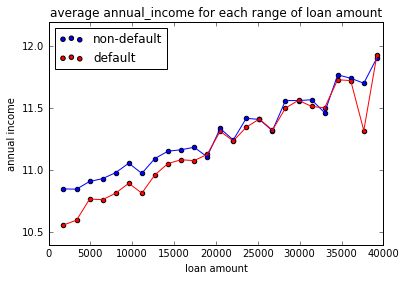

In [409]:
bin_means_0, bin_edges_0, binnumber_0 = stats.binned_statistic(x['loan_amnt'][y == 0], x['annual_inc'][y == 0], statistic='mean', bins=25)
bin_width_0 = (bin_edges_0[1] - bin_edges_0[0])
bin_centers_0 = bin_edges_0[1:] - bin_width_0/2

bin_means_1, bin_edges_1, binnumber_1 = stats.binned_statistic(x['loan_amnt'][(y == 1) & (x['annual_inc'].isnull().values == False)], x['annual_inc'][(y == 1)& (x['annual_inc'].isnull().values == False)], statistic='mean', bins=25)
bin_width_1 = (bin_edges_1[1] - bin_edges_1[0])
bin_centers_1 = bin_edges_1[1:] - bin_width_1/2

plt.scatter(bin_centers_0, bin_means_0, c= 'blue', label = 'non-default')
plt.plot(bin_centers_0, bin_means_0, c= 'blue')
plt.scatter(bin_centers_1, bin_means_1, c='red', label = 'default')
plt.plot(bin_centers_1, bin_means_1, c='red')

plt.title("average annual_income for each range of loan amount")
plt.xlabel('loan amount')
plt.ylabel('annual income')
plt.legend(loc = 2)
plt.xlim(0, 40000)
plt.show()

&nbsp;&nbsp; Then I plotted the curves of the debt-to-income ratio against the loan's amount in the same way as above. Generally the borrowers of defaulted loans have higher debt-to-income ratios than the borrowers of non-default loans. Similarly, the two curves are clearly separated at small loan amounts, but they converge towards each other as the loan amount grows. This indicates that the debt-to-income ratio can help predict the results of small loans, but for large amount loans, the influence of debt-to-income ratio on loan's outcome is not very clear.

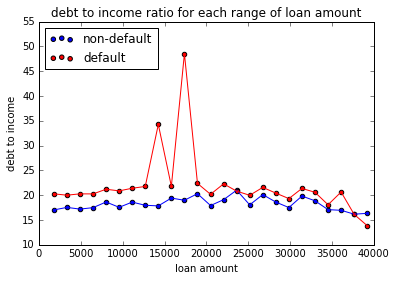

In [146]:
bin_means_0, bin_edges_0, binnumber_0 = stats.binned_statistic(x['loan_amnt'][y == 0], x['dti'][y == 0], statistic='mean', bins=25)
bin_width_0 = (bin_edges_0[1] - bin_edges_0[0])
bin_centers_0 = bin_edges_0[1:] - bin_width_0/2

bin_means_1, bin_edges_1, binnumber_1 = stats.binned_statistic(x['loan_amnt'][y == 1], x['dti'][y == 1], statistic='mean', bins=25)
bin_width_1 = (bin_edges_1[1] - bin_edges_1[0])
bin_centers_1 = bin_edges_1[1:] - bin_width_1/2

plt.scatter(bin_centers_0, bin_means_0, c= 'blue', label = 'non-default')
plt.plot(bin_centers_0, bin_means_0, c= 'blue')
plt.scatter(bin_centers_1, bin_means_1, c='red', label = 'default')
plt.plot(bin_centers_1, bin_means_1, c='red')

plt.title("debt to income ratio for each range of loan amount")
plt.xlabel('loan amount')
plt.ylabel('debt to income')
plt.legend(loc = 2)
plt.xlim(0, 40000)
plt.show()

&nbsp;&nbsp; The type of home ownership is also related with loan outcomes, since home ownership is a strong indication of the borrower's financial situation and also influences the borrower's disposable income. From the barplot below we can see that the borrowers with "Rent" type of home ownership have a higher proportion of defaulted loans than the borrowers with "Mortgage" and "Own" types of home ownership. This makes sense because people who own a house and people who got approved for mortgage are more likely to have stable income cash flows and good credit history than people who rent a house to live.

The proportion of default by different types of home ownership is:
MORTGAGE    0.298404
OWN         0.329897
RENT        0.410831
Name: home_ownership, dtype: float64


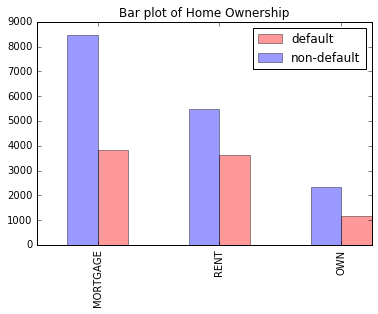

In [411]:
## one observation with home_ownership == any, drop it
# y = y[x['home_ownership'].values != 'ANY']
# x = x[x['home_ownership']!= 'ANY']

print "The proportion of default by different types of home ownership is:"
print x[y == 1].home_ownership.value_counts()/(x[y == 1].home_ownership.value_counts() + x[y == 0].home_ownership.value_counts())
ax1 = plt.subplot()
x[y == 1].home_ownership.value_counts().plot(kind='bar', color = 'red', position=0,width=0.25,alpha = 0.4, axes = ax1, label = 'default')
x[y == 0].home_ownership.value_counts().plot(kind='bar', color = 'blue',position=1,width=0.25, alpha = 0.4, axes = ax1, label = 'non-default')


plt.legend()
plt.title('Bar plot of Home Ownership')
plt.show()

## 2.2 Feature Selection

&nbsp;&nbsp; In this part, I used three methods to select the most predictive features for loan's outcome: Lasso (L1 regularization), Random Forest Importance Rank, and Step-wise Backward Feature Selection. These three methods are used in combination to select the "best" set of predictors according to Akaike information criterion (AIC).
&nbsp;&nbsp; The most relevant features include loan's amount, term, verification status, purpose, and the borrower's home ownership, annual income, employment length, number of open accounts, etc. 

# 3. Classification

## 3.1 Classification Models


&nbsp;&nbsp; With the predictors selected above, I built a variety of classification models: Logistic Regression, LDA and QDA, Random Forest, and Gradient Boost. Each classification model was built using the training data set, and the hyperparameters were tuned using cross-validaiton method. The models were evaluated using a comprehensive evaluation metrics such as True (False) Positive (Nagative) predictions as well as recall and precisions rates. Also I calculated the Accuracy and AUC scores and the "Pass rate" (i.e. the proportion of the predicted non-default loans among all loans). The evaluation metrics are computed on the test data set. 

&nbsp;&nbsp; The result table of Logistic regression is listed below:

In [504]:
clf_slc = Logit()
clf_slc.fit(X_train_sel, y_train)
y_predict_slc = clf_slc.predict(X_test_sel)
y_predict_prob_slc = clf_slc.predict_proba(X_test_sel)[:,1]

fpr_slc, tpr_slc, _ = roc_curve(y_test, y_predict_prob_slc)

print "**************************************************"
print " Sklearn logistic regression Model performance report"
print "**************************************************"
predict_table(y_test, y_predict_slc)
print "auc score = ", roc_auc_score(y_test, y_predict_prob_slc)

**************************************************
 Sklearn logistic regression Model performance report
**************************************************
Total number of test data: 7473
True  Positive:            399.0
True  Negative:            4541.0
False Positive:            348.0
False Negative:            2185.0
Recall    on class 1:      0.154411764706
Precision on class 1:      0.534136546185
Recall    on class 0:      0.92881979955
Precision on class 0:      0.675141242938
Accuracy:                  0.661046433828
Pass rate:            0.90004014452
auc score =  0.654660316614


## 3.2 Credit Grades

&nbsp;&nbsp; Lending Club evaluates the defaul risks of each loan and assigns a credit grade accordingly, with credit grade "A" meaning low default risks and credit grade "F" high default risks. The distribution of Lending Club credit grade and the default rate of each credit grade are listed below:

Proportion of loans in each Lending Club credit grade:
A    0.117151
B    0.240927
C    0.292757
D    0.174843
E    0.110005
F    0.048137
G    0.016180
Name: grade, dtype: float64
Default rate for each Lending Club credit grade:
A    0.139822
B    0.245292
C    0.343527
D    0.433525
E    0.512409
F    0.555463
G    0.615385
Name: grade, dtype: float64


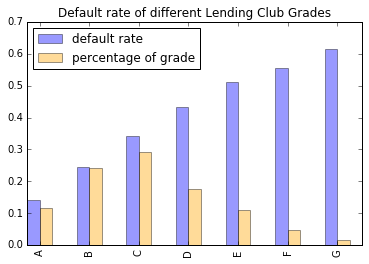

In [144]:
grade_non_default = data[y == 0].grade.copy()
grade_non_default = grade_non_default.value_counts().sort_index()

grade_default = data[y == 1].grade.copy()
grade_default = grade_default.value_counts().sort_index()


grade = data.grade.copy().value_counts().sort_index()
grade_proportion = grade /data.shape[0]
print "Proportion of loans in each Lending Club credit grade:"
print grade_proportion
default_rate = (grade_default) / grade
print "Default rate for each Lending Club credit grade:"
print default_rate
default_rate.plot(kind='bar', color = 'blue', alpha = 0.4, position=1, width=0.25,label = 'default rate')
grade_proportion.plot(kind='bar', color = 'orange', alpha = 0.4, position=0, width=0.25,label = 'percentage of grade')
plt.legend(loc = 'best')
plt.title('Default rate of different Lending Club Grades')
plt.show()

&nbsp;&nbsp; In the above barplot, the orange bars represent the proportions of loans in each credit grade, and the blue bars represent the default rates of the corresponding credit groups. For example, Lending Club assigns a credit grade "A" to 11.7% of its loans, and the default rate of "A" loans is 14.0%.

&nbsp;&nbsp; To compare my prediction results with Lending Club's credit grade, I assigned new credit grades ("A", "B", "C", "D", "E", "F", "G") to the loans according to the predicted default probabilities. For the sake of comparability, I set the proportion of each credit grade identical to that of Lending Club. The barplot below shows the default rates among the new credit grades:

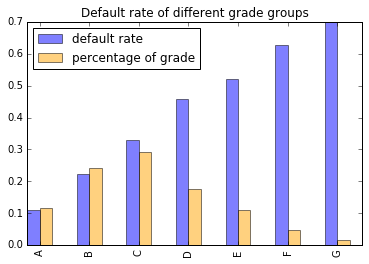

In [145]:
proba, label = (list(x) for x in zip(*sorted(zip(y_predict_prob_BLR, y_test))))
proba = np.array(proba)
label = np.array(label)

default_rate = []
last_pct = 0
accu_pp = 0

for pp in grade_proportion:
    accu_pp += pp
    pct = np.percentile(proba, accu_pp*100)
    rate = np.mean(label[np.array([item > last_pct and item <= pct for item in proba])])
    default_rate.append(rate)
    last_pct = pct

default_rate = pd.Series(default_rate)
default_rate.plot(kind='bar', color = 'blue', alpha = 0.5, position=1, width=0.25,label = 'default rate')
grade_proportion.plot(kind='bar', color = 'orange', alpha = 0.5, position=0, width=0.25,label = 'percentage of grade')

plt.legend(loc = 'best')
plt.title('Default rate of different grade groups')
plt.show()

&nbsp;&nbsp; The orange bars represent the proportions of loans in each credit grade (which is exactly the same as the orange bars in the barplot above), and the blue bars represent the default rates of the corresponding credit groups. For example, Lending Club assigns a credit grade "A" to 11.7% of its loans, and the default rate of "A" loans about 11.4%.

&nbsp;&nbsp; By comparing the above two plots, it is noticeable that the default rates of new credit grades "A" and "B" is significantly lower than the corresponding default rates of Lending Club credit grades. This improvement is beneficial to risk-averse investors who invest solely in loans with a grade higher than "B", since their expected loss is lowered with the interest returns and number of selectable loans not influenced.

# 4. Future Work

1. If more information could be found about the borrower, such as family size, age, pension benefits and so on, the prediction results can be improved further. 

2. The principal component analysis could be employed to extract the most useful information from the data set and to generate powerful components to use in the classification models.

3. As discovered in the data visualization part (2.1), the borrower's annual income and debt-to-income ratio have very different influence in loan outcomes under different loan sizes. This suggests that small and large sized loans may be intrinsically different, so that it could be better to first stratify loans by size and then build prediction models for different range of loan size.